# polarityReversal

## initiation 

In [298]:
import os
import mne # import the processing tools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import shutil
from itertools import repeat

parent_dir = 'D:/CHF/polarityReversal/'
base_dir = 'D:/CHF/polarityReversal/eeg/'
os.chdir(base_dir)

### definition of some parameters

In [299]:
screenfreq=90.0 #Hz Monitor frame rate
time_per_frame=1.0/screenfreq
Ncond=12 # number of conditions
stimfreq=[1.875,3.75,7.5,15]
stimfreq2=[i for i in stimfreq for _ in range(3)]
resolution_eeg=0.002 # temporal resolution of the eeg, equals to 1 / EEG-Frequency

stimdurations=[0.546,0.278,0.144,0.078]
stimdurations2=[i for i in stimdurations for _ in range(3)]
hemifields=['full','lower','upper'] # this was upside down in the initial processing, but now changed upper to lower and vice versa, because wrong definition in paradigm found
hemifields2=[i for _ in range(3) for i in hemifields]

# for plotting?
tmin     = 0.
tmax     = 3.

### trigger handling

In [300]:
min_triggerlength=[]
max_triggerlength=[]
for i in range(2,14): # den Trigger, der den einzelnen Stimulus onset definiert (1 frame), mal weggelassen
    min_triggerlength.append(math.floor((i*time_per_frame-resolution_eeg*1.5)*1000)/1000) #abrunden
    max_triggerlength.append(math.ceil((i*time_per_frame+resolution_eeg*1.5)*1000)/1000) #aufrunden

### timings of the events / blocks

In [301]:
# these are valid for subjects 4-10
single_event_timings=[[322, 868, 1413, 1959],
                      [322, 601, 879, 1157, 1435, 1714, 1992, 2270],
                      [322, 467, 612, 756, 901, 1046, 1190, 1335, 1480, 1625, 1769, 1914, 2060, 2204, 2349],
                      [322, 400, 478, 556, 634, 712, 790, 868, 946, 1023, 1101, 1179, 1257, 1335, 1413, 1491, 1569, 1647, 1725, 1804, 1882, 1960, 2038, 2116, 2194, 2272, 2349, 2427, 2505, 2583]]
single_period_times= [546,279,145,78]
### <- TODO is the same as stimdurations * 1000

### some MNE specific properties

In [302]:
# turn information status messages on, if off, type: mne.set_log_level('WARNING')
mne.set_log_level('INFO')

### colormaps for plotting

In [303]:
# define some colormaps
colormapQ3a=[[166/255,206/255,227/255], [31/255,120/255,180/255], [178/255,223/255,138/255]]
colormapQ4a=[(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]

# chose the colormap
cm       = colormapQ4a

### functions for analysis

#### folder / file handling

In [304]:
def fileHandling(sub):
    if sub<10:
        subs = '0' + str(sub)
    else:
        subs = str(sub)
    
    # delete old files
    try:
        shutil.rmtree(base_dir + os.sep + subs + os.sep + 'data')
        shutil.rmtree(base_dir + os.sep + subs + os.sep + 'plots')
    except:
        pass
    
    # make new folders
    if not os.path.isdir(base_dir + os.sep + subs + os.sep + 'data'):
        os.makedirs(base_dir + os.sep + subs + os.sep + 'data')
    if not os.path.isdir(base_dir + os.sep + subs + os.sep + 'plots'):
        os.makedirs(base_dir + os.sep + subs + os.sep + 'plots')
    
    return subs

#### event conversion

In [305]:
triggerDic = {11:1,12:1, # converts the trigger lengths (in number of scans/time points) to the index of different conditions
              16:2,17:2,
              22:3,23:3,
              27:4,28:4,
              33:5,34:5,
              38:6,39:6,
              44:7,45:7,
              50:8,51:8,
              55:9,56:9,
              61:10,62:10,
              66:11,67:11,
              72:12,73:12} # "5" and "6" are single stimulus onsets

def eventConversion(events, events_id, plot = False):
    s1 = events [events[:,2] == 1]
    s2 = events [events[:,2] == 2]

    from collections import Counter
    diff = s2[:,0] - s1[:,0]
    k = list(Counter(diff).keys()) # equals to list(set(words))
    v = list(Counter(diff).values()) # counts the elements' frequency
    
    if plot: # optional, for debugging or checking which "trigger durations" occured how often
        f = sns.barplot(x = k,y = v)
        f.set_yscale("log")
    
    # apply trigger to stimulus conversion
    events_new = [] # transform to np array later
    ecounter = 0
    for e in events:
        if e[2] != 1:
            continue
        # change value
        try:
            e[2] = triggerDic[diff[ecounter]]
            events_new.append(e.tolist())
            #print(e)
        except:
            pass
        ecounter += 1
        #if ecounter > 50:
        #    break
    events_new = np.asarray(events_new)
    events_id_new = {"Cond_"+str(i):i for i in range(1,13)}
    return events_new, events_id_new

### define electrodes for processing

In [306]:
electrodes_of_interest = ['Oz','Pz']
reference_electrodes   = [['TP9','TP10']]

## single subjects analyses

In [515]:
eoi = electrodes_of_interest[0]
ref = reference_electrodes[0]

subs = fileHandling(5)

### pre processing

Extracting parameters from D:/CHF/polarityReversal/eeg/\05\RK_20005.vhdr...
Setting channel info structure...
Reading 0 ... 2427399  =      0.000 ...  4854.798 secs...


<ipython-input-517-eb71bc71b6df>:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw     = mne.io.read_raw_brainvision(base_dir + os.sep + subs + os.sep + 'RK_200' + subs + '.vhdr', preload=True)


EEG channel type selected for re-referencing
Applying a custom EEG reference.


C:\Users\Roman\Anaconda3\envs\mne\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Roman\Anaconda3\envs\mne\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-517-eb71bc71b6df>:7: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi`

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 48 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 47.50 Hz
- Upper transition bandwidth: 11.88 Hz (-6 dB cutoff frequency: 53.44 Hz)
- Filter length: 139 samples (0.278 sec)

Using channel Fp1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition b

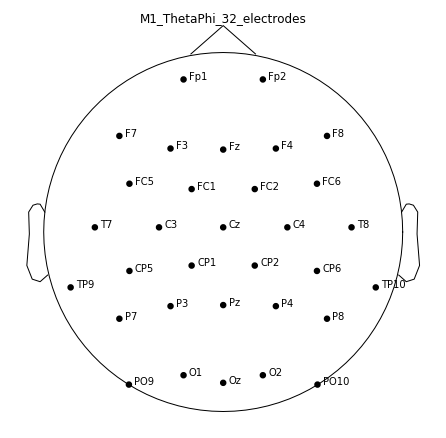

In [517]:
# load data
raw     = mne.io.read_raw_brainvision(base_dir + os.sep + subs + os.sep + 'RK_200' + subs + '.vhdr', preload=True)
eoi_idx = raw.ch_names.index(eoi)

# define the distribution of electrodes
montage = mne.channels.read_montage(parent_dir + '/electrode_positions/M1_ThetaPhi_32_electrodes.txt', ch_names=None, path=None, unit='m', transform=False)    
raw.set_montage(montage)
f = montage.plot(kind = "topomap", show=False)

# re-reference the channels
raw.set_eeg_reference(ref_channels=ref)

# low pass filtering
raw.filter(None, 47.5, h_trans_bandwidth='auto', filter_length='auto', phase='zero')

# blink detection
eog_events1 = mne.preprocessing.find_eog_events(raw, ch_name='Fp1')
eog_events2 = mne.preprocessing.find_eog_events(raw, ch_name='Fp2')
eog_events = np.concatenate((eog_events1, eog_events2))
n_blinks = len(eog_events)
onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25 # Center to cover the whole blink with full duration of 0.5s
durations = np.repeat(0.5, n_blinks)
descriptions = ['bad blink'] * n_blinks
raw.set_annotations = mne.Annotations(onsets, durations, descriptions, orig_time=raw.info['meas_date'])


### epoching

In [518]:
events, events_id = mne.events_from_annotations(raw)

Used Annotations descriptions: ['Comment/actiCAP Data On', 'Comment/actiCAP USB Power On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2']


In [519]:
events, events_id = eventConversion(events, events_id)

#### plot event distribution

<ipython-input-520-83f0d983b51f>:1: RuntimeWarning: More events than colors available. You should pass a list of unique colors.
  f = mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=events_id, show=False)


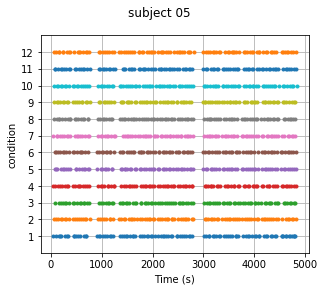

In [520]:
f = mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=events_id, show=False)
f.suptitle("subject " + subs, x = 0.4)
plt.legend("", frameon = False)
plt.ylabel("condition")
f.savefig(base_dir + os.sep + subs + os.sep + 'plots' + os.sep + 'condition_order.png', dpi=300)

In [521]:
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude='bads')  # pick the channels

1201 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1201 events and 1501 original time points ...
0 bad epochs dropped


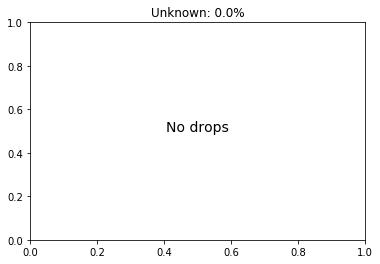

In [522]:
epochs = mne.Epochs(raw, events, events_id,
                    tmin = 0.,
                    tmax = 3.,
                    proj=True, picks=picks,
                    baseline=(0, 0.322) ,
                    preload=True,
                    reject={"eeg":4e-4}, # empirisch?
                    reject_by_annotation = True,
                    detrend=0) # detrend = 0: mean centering, detrend = 1 linear detrending 
epochs.drop_bad()
f = epochs.plot_drop_log(show=False) 

<ipython-input-523-85160d9826c2>:4: RuntimeWarning: More events than colors available. You should pass a list of unique colors.
  show = False)


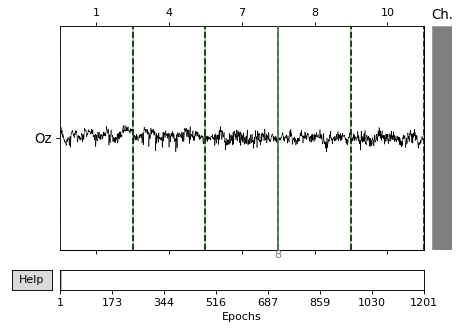

In [523]:
f = epochs.plot(picks = eoi_idx,
            n_epochs=5,
            events = events,
            show = False)

In [524]:
evoked = epochs.average?

In [ ]:
evoked = epochs.average

In [525]:
evoked = {"Cond_"+str(i) : epochs["Cond_"+str(i)].average() for i in range(1,4)} # change to 13 !!!

In [526]:
evoked

{'Cond_1': <Evoked  |  'Cond_1' (average, N=103), [0, 3] sec, 32 ch, ~463 kB>,
 'Cond_2': <Evoked  |  'Cond_2' (average, N=100), [0, 3] sec, 32 ch, ~463 kB>,
 'Cond_3': <Evoked  |  'Cond_3' (average, N=99), [0, 3] sec, 32 ch, ~463 kB>}

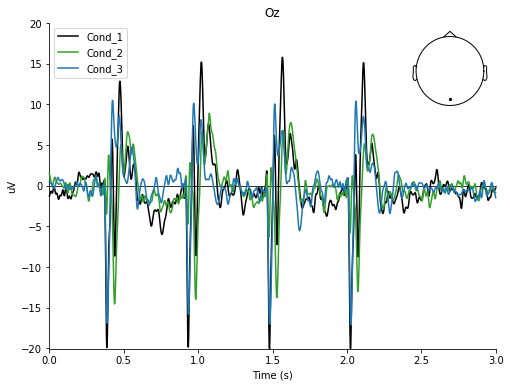

[<Figure size 576x432 with 2 Axes>]

In [527]:
mne.viz.plot_compare_evokeds(evoked, picks = eoi_idx, colors=cm)

In [549]:
df = epochs.to_data_frame(picks=eoi_idx, scalings=1, scaling_time=1000, index=None, copy = True, long_format=True).drop(
    ["ch_type","channel"], axis = 1)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [550]:
df.head(n=400)

,condition,epoch,time,observation
0,Cond_1,0,0.0,3.784130e-06
1,Cond_1,0,2.0,3.294685e-06
2,Cond_1,0,4.0,2.948872e-06
3,Cond_1,0,6.0,2.741735e-06
4,Cond_1,0,8.0,2.699561e-06
...,...,...,...,...
395,Cond_1,0,790.0,2.254801e-06
396,Cond_1,0,792.0,2.272484e-06
397,Cond_1,0,794.0,2.009261e-06
398,Cond_1,0,796.0,1.399670e-06


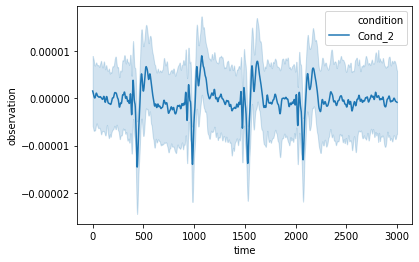

In [563]:
g = sns.lineplot(x="time", y="observation",
                  hue="condition", #hue="event", style="event", col = "condition"
                  data=df[df.condition == "Cond_2"],
                err_style = "band",
                ci = "sd", #99 # int or "sd"
                )

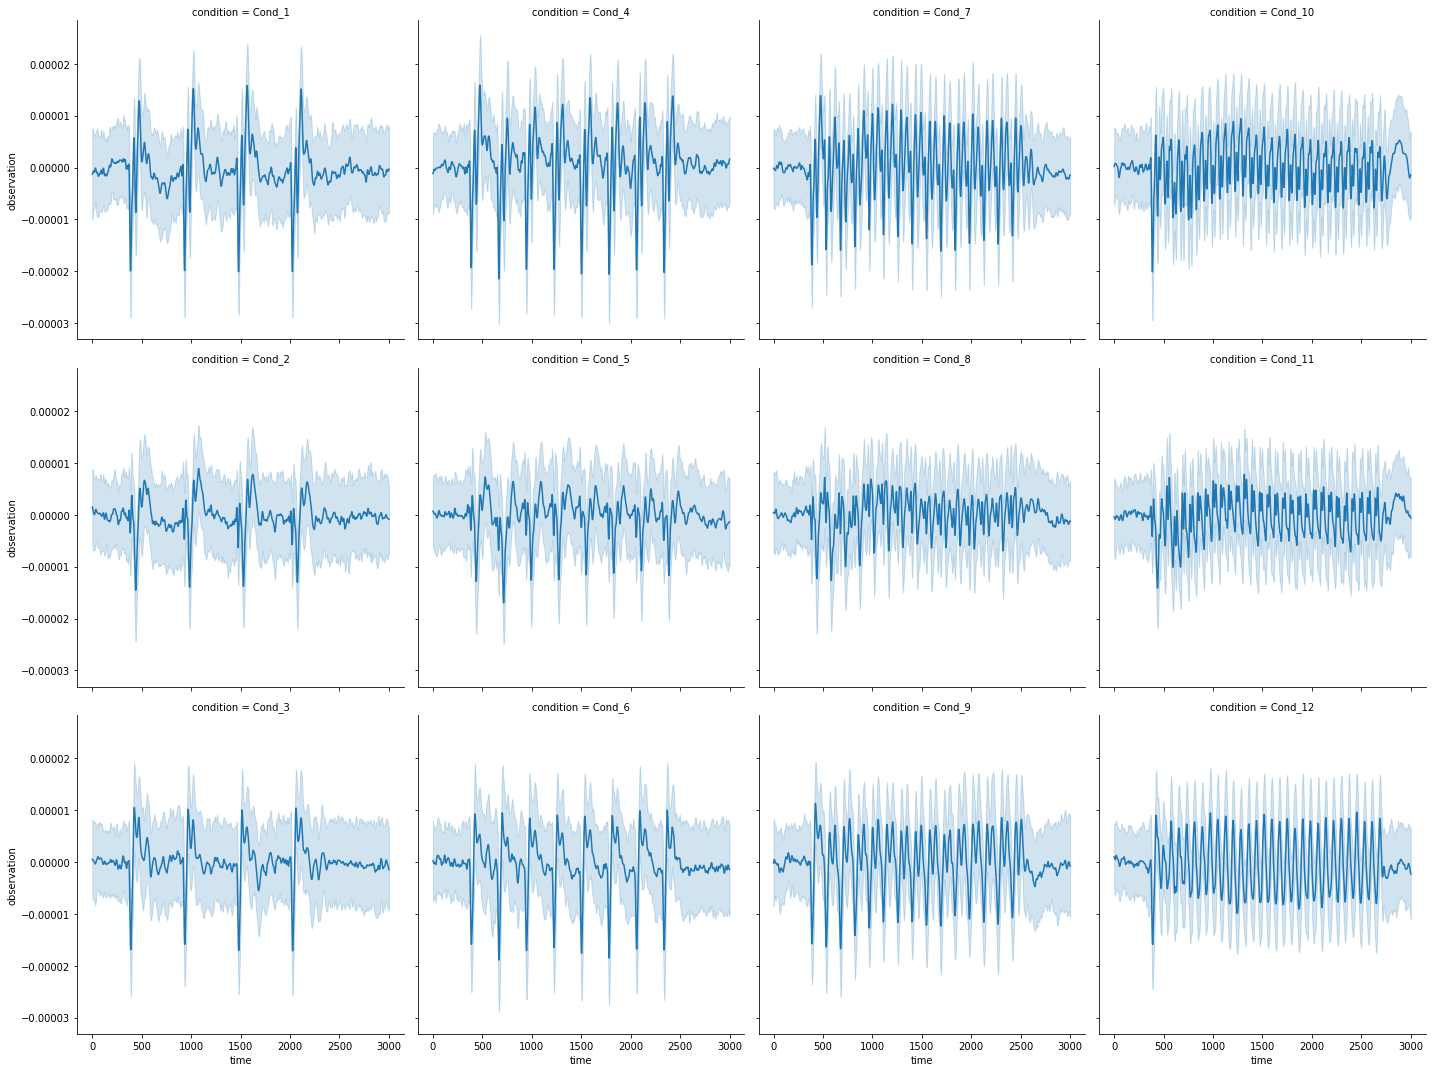

In [595]:
sortCond = ["Cond_1","Cond_4","Cond_7","Cond_10",
            "Cond_2","Cond_5","Cond_8","Cond_11",
            "Cond_3","Cond_6","Cond_9","Cond_12"]
g = sns.relplot(x="time", y="observation",
                  col="condition", # style="condition", hue = "condition"
                  data=df,
                err_style = "band",
                ci = "sd", #99 # int for %ci or "sd"
                kind="line",
                col_wrap=4,
                col_order = sortCond
                )

In [558]:
sns.lineplot?asd

In [533]:
epochs.to_data_frame?

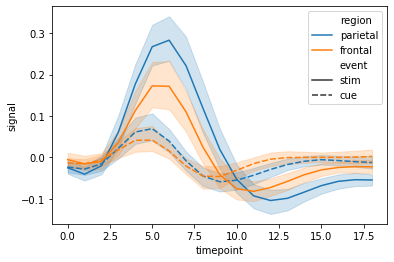

In [551]:
fmri = sns.load_dataset("fmri")
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

In [531]:
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


In [ ]:
def epochsToDataFrame(epochs):
    '''function to turn epoched data into data frames'''
    import pandas as pd
    
    
    return df
    

In [433]:
montage.dig

[<DigPoint |     EEG #1 : (-29.3, 90.3, -3.3) mm    : unknown frame>,
 <DigPoint |     EEG #2 : (29.3, 90.3, -3.3) mm     : unknown frame>,
 <DigPoint |     EEG #3 : (-76.8, 55.8, -3.3) mm    : unknown frame>,
 <DigPoint |     EEG #4 : (-51.8, 63.9, 47.5) mm    : unknown frame>,
 <DigPoint |     EEG #5 : (0.0, 68.3, 66.0) mm      : unknown frame>,
 <DigPoint |     EEG #6 : (51.8, 63.9, 47.5) mm     : unknown frame>,
 <DigPoint |     EEG #7 : (76.8, 55.8, -3.3) mm     : unknown frame>,
 <DigPoint |     EEG #8 : (-84.3, 32.4, 29.4) mm    : unknown frame>,
 <DigPoint |     EEG #9 : (-35.6, 35.6, 80.6) mm    : unknown frame>,
 <DigPoint |    EEG #10 : (35.6, 35.6, 80.6) mm     : unknown frame>,
 <DigPoint |    EEG #11 : (84.3, 32.4, 29.4) mm     : unknown frame>,
 <DigPoint |    EEG #12 : (-94.9, -0.0, -3.3) mm    : unknown frame>,
 <DigPoint |    EEG #13 : (-68.3, -0.0, 66.0) mm    : unknown frame>,
 <DigPoint |    EEG #14 : (0.0, 0.0, 95.0) mm       : unknown frame>,
 <DigPoint |    EEG 

In [439]:
montage = mne.channels.read_dig_montage(parent_dir + '/electrode_positions/M1_ThetaPhi_32_electrodes_test.txt')


<ipython-input-439-93200f89f064>:1: DeprecationWarning: Using "read_dig_montage" is deprecated and will be removed in v0.20. Use read_dig_polhemus_isotrak.
  montage = mne.channels.read_dig_montage(parent_dir + '/electrode_positions/M1_ThetaPhi_32_electrodes_test.txt')


ValueError: Data must be of shape (n, 3) instead of (32, 2)

In [435]:
raw.set_montage(montage)

ValueError: Points have to be provided as one dimensional arrays of length 3.

In [ ]:
# define the distribution of electrodes
montage = mne.channels.read_montage(parent_dir + '/electrode_positions/M1_ThetaPhi_32_electrodes.txt', ch_names=None, path=None, unit='m', transform=False)    
raw.set_montage(montage)

In [450]:
mne.channels._standard_montage_utils._read_theta_phi_in_degrees(parent_dir + '/electrode_positions/M1_ThetaPhi_32_electrodes.txt',
                                                               head_size = None,
                                                               fid_names = None)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable cos method

In [292]:
epochs["Condition_1"].get_data().shape

(106, 32, 1501)

In [293]:
c1 = epochs["Condition_1"].get_data()
c1 = c1.transpose(2,1,0)
c1.shape

(1501, 32, 106)

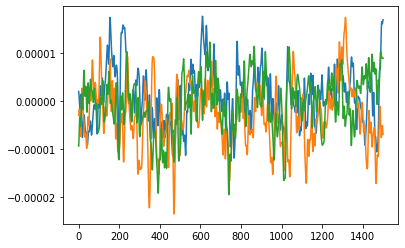

In [294]:
plt.plot(c1[:,eoi_idx,:3])

In [596]:
stimfreq2

[1.875, 1.875, 1.875, 3.75, 3.75, 3.75, 7.5, 7.5, 7.5, 15, 15, 15]

In [598]:
hemifields2

['full', 'lower', 'upper', 'full', 'lower', 'upper', 'full', 'lower', 'upper']